In [1]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

## Getting the underreporting statistic for each year

Below is a list of all the questions we need to keep as well as from which years onwards they were asked.

---

We generally use the questions BQ90D and BQ90DA to determine underreporting for each year.


In [2]:
# Load the PAS questions data
df = pd.read_pickle(r'crime_data/PAS_detailed.pkl')
df['Year-Month'] = pd.to_datetime(df['Year-Month'], format='%Y-%m-%d').dt.date

In [3]:
# lists of columns to keep in the final df
important_cols = ["Year-Month", "ward_n", "ward", "Borough"]  # w/o Week and BCU as those both start in April 2020

In [4]:
def calc_wards(df, question_column):
    # Ensure the question column is binary (1 for 'No' and 0 for 'Yes')
    if set(df[question_column].unique()) != {0, 1}:
        raise ValueError("Question column must be binary with 1 for 'No' and 0 for 'Yes'")

    # Group by the relevant columns and calculate the proportion of 'No' responses
    grouped = df.groupby(["Year-Month", "Borough", "ward_n"]).agg(
        no_count=(question_column, 'sum'),
        total_count=(question_column, 'count')
    ).reset_index()

    # Calculate the proportion of 'No' responses
    grouped["Proportion_no"] = grouped["no_count"] / grouped["total_count"]
    grouped["Total_prop_no"] = grouped["no_count"] / grouped.shape[0]
    
    # Add the question column to the result
    grouped["Question"] = question_column
    
    # Select the desired columns
    result_df = grouped[["Year-Month", "Borough", "ward_n", "Question", "total_count", "no_count", "Proportion_no", "Total_prop_no"]]
    
    return result_df



### 2015 - 2017
- BQ90A: Have you been a victim of crime or Anti-Social Behaviour in the last 12 months? => yes/no
- BQ90B: Thinking about the most recent incident, was this in your local area, elsewhere in London or outside of London? => _remove "Outside of London"_
- BQ90C: Was it...? => types of crime
- **BQ90D: Did you report this to anyone? => yes/no**
- SQ109CA's: Who did you report it to? => _filter (below is the underreporting)_ ==>>  QUESTIONS NOT IN DATAFRAME
    - **SQ109CAD: Residents Association**
    - **SQ109CAG: School**
    - **SQ109CAH: Neighbourhood Watch**
    - **SQ109CAJ: Landlord/Warden**
    - **SQ109CAK: To a local group/at a local meeting**

__Extra:__
- NSQ190's: Did anything happen after you reported it?
- PQ98A: In the last 12 months has anyone tried to discourage you from reporting a crime to the police? IF YES - Who was that?
- PQ98ABA: Who was that? Police Officer
- PQ98ABB: Who was that? Another member of the police service, including someone over the phone
- PQ98B's: In what way did the police discourage you?
- Q122: Have you heard of anyone in your neighbourhood being a victim of crime or Anti-Social Behaviour in the past year?
- Q123: Have you heard of anyone in your family being a victim of crime or Anti-Social Behaviour in the past year?
- Q124: Do you know if your neighbour, friend or family member reported the crime or Anti-Social Behaviour to the police?
- Q125: Has their experience affected your opinion of the police?
- Q126's: How has this affected your opinion of the police?

### 2017/18 -2018/19
__Extra:__
- XQ191's: Why did you not report this to the police?
- XQ192: If something like this happened again would you report it to the police? => yes/no  

In [5]:
## BQ90D asked from 2015 to start of 2019 -- cannot specify to who it was reported
df_1519 = df[important_cols + ["BQ90D"]][~(df["BQ90D"].isna())].copy()

df_1519["BQ90D"] = df_1519["BQ90D"].map({
    'Yes': 0,
    'No': 1
})

# Total underreporting 2015 - 2019
print(df_1519.shape)
print(df_1519[["BQ90D"]].value_counts())
print("Percentage of underreporting 2015-2019: ", df_1519[df_1519["BQ90D"] == 1.0].shape[0]/df_1519.shape[0])

df2 = calc_wards(df_1519, "BQ90D")
df2

(5295, 5)
BQ90D
0        3881
1        1414
Name: count, dtype: int64
Percentage of underreporting 2015-2019:  0.26704438149197357


,Year-Month,Borough,ward_n,Question,total_count,no_count,Proportion_no,Total_prop_no
0,2015-04-01,Barking and Dagenham,Becontree,BQ90D,1,0,0.0,0.000000
1,2015-04-01,Barking and Dagenham,Eastbury,BQ90D,1,0,0.0,0.000000
2,2015-04-01,Barking and Dagenham,Heath,BQ90D,2,1,0.5,0.000258
3,2015-04-01,Barking and Dagenham,Parsloes,BQ90D,2,0,0.0,0.000000
4,2015-04-01,Barnet,Burnt Oak,BQ90D,1,0,0.0,0.000000
...,...,...,...,...,...,...,...,...
3865,2019-03-01,Waltham Forest,Lea Bridge,BQ90D,1,1,1.0,0.000258
3866,2019-03-01,Wandsworth,Thamesfield,BQ90D,1,1,1.0,0.000258
3867,2019-03-01,Westminster,Church Street,BQ90D,1,1,1.0,0.000258
3868,2019-03-01,Westminster,Hyde Park,BQ90D,2,1,0.5,0.000258


### 2019/20 - 2020/21

- **BQ90DA: Did you report it to the police? => yes/no**

__Extra:__
- XQ119B: As a result of your contact with the police on this occasion, please tell me if your opinion is now better, worse or has not changed?

In [6]:
## BQ90DA asked from 2019 to start of 2021 -- specifically for the police
df_1921 = df[important_cols + ["BQ90DA"]][~(df["BQ90DA"].isna())].copy()

df_1921["BQ90DA"] = df_1921["BQ90DA"].map({
    'Yes': 0,
    'No': 1
})

# Total underreporting 2019 - 2021
print(df_1921.shape)
print(df_1921[["BQ90DA"]].value_counts())
print("Percentage of underreporting 2019-2021: ", df_1921[df_1921["BQ90DA"] == 1.0].shape[0]/df_1921.shape[0])

df3 = calc_wards(df_1921, "BQ90DA")
df3

(3835, 5)
BQ90DA
0         2682
1         1153
Name: count, dtype: int64
Percentage of underreporting 2019-2021:  0.30065189048239893


,Year-Month,Borough,ward_n,Question,total_count,no_count,Proportion_no,Total_prop_no
0,2019-04-01,#N/A,Hobbayne,BQ90DA,1,0,0.0,0.000000
1,2019-04-01,#N/A,St George's,BQ90DA,1,0,0.0,0.000000
2,2019-04-01,Barking and Dagenham,Goresbrook,BQ90DA,1,0,0.0,0.000000
3,2019-04-01,Barking and Dagenham,Valence,BQ90DA,1,1,1.0,0.000323
4,2019-04-01,Barnet,Coppetts,BQ90DA,1,0,0.0,0.000000
...,...,...,...,...,...,...,...,...
3092,2021-03-01,Wandsworth,Fairfield,BQ90DA,1,0,0.0,0.000000
3093,2021-03-01,Wandsworth,Thamesfield,BQ90DA,1,1,1.0,0.000323
3094,2021-03-01,Westminster,Hyde Park,BQ90DA,1,1,1.0,0.000323
3095,2021-03-01,Westminster,West End,BQ90DA,1,0,0.0,0.000000


### 2021/2022

**NOTE:** This specific year does not have BQ90D(A), hence we need to take weighted averages of the negative answers of the following:

- XQ59C: How likely or unlikely would you be to report the following to the police...? Someone you know personally, who you think might be involved in terrorism
- XQ59D: How likely or unlikely would you be to report the following to the police...? Someone you know personally, who you think might be vulnerable to radicalisation

In [7]:
# Mapping scales to interpretable values -- possible underreporting
df["XQ59C"] = df["XQ59C"].map({
    'Very likely': 0,
    'Fairly likely': 0,
    'Neither likely nor unlikely': 0,
    'Fairly unlikely': 1,
    'Very unlikely': 1,
    'Refused': np.nan
})

df["XQ59D"] = df["XQ59D"].map({
    'Very likely': 0,
    'Fairly likely': 0,
    'Neither likely nor unlikely': 0,
    'Fairly unlikely': 1,
    'Very unlikely': 1,
    'Refused': np.nan
})

In [8]:
# Total underreporting 2021 - 2022 -- difficult questions that don't cover all of underreporting (only on terrorism and radicalization)
df_2122 = df[important_cols + ["XQ59C", "XQ59D"]][~((df["XQ59C"].isna()) | (df["XQ59D"].isna()))].copy()

print(df_2122.shape)
print(df_2122[["XQ59C"]].value_counts())
print("Percentage of possible underreporting terrorism 2021-2022: ", df_2122[df_2122["XQ59C"] == 1.0].shape[0]/df_2122.shape[0])
print(df_2122[["XQ59D"]].value_counts())
print("Percentage of possible underreporting radicalization 2021-2022: ", df_2122[df_2122["XQ59D"] == 1.0].shape[0]/df_2122.shape[0])

(21142, 6)
XQ59C
0.0      20296
1.0        846
Name: count, dtype: int64
Percentage of possible underreporting terrorism 2021-2022:  0.04001513574874657
XQ59D
0.0      20028
1.0       1114
Name: count, dtype: int64
Percentage of possible underreporting radicalization 2021-2022:  0.05269132532399962


In [9]:
# Combining cells
df_2122 = df_2122.astype({"XQ59C": int, "XQ59D": int})
df_2122["XQ59CD"] = df_2122["XQ59C"] | df_2122["XQ59D"]
df4 = calc_wards(df_2122, "XQ59CD")
df4

,Year-Month,Borough,ward_n,Question,total_count,no_count,Proportion_no,Total_prop_no
0,2018-07-01,,Blackwall & Cubitt Town,XQ59CD,2,0,0.0,0.0
1,2018-07-01,,Chapel End,XQ59CD,1,0,0.0,0.0
2,2018-07-01,,Colindale,XQ59CD,1,0,0.0,0.0
3,2018-07-01,,Greenwich West,XQ59CD,1,0,0.0,0.0
4,2018-07-01,,Junction,XQ59CD,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...
4566,2020-03-01,Westminster,Harrow Road,XQ59CD,8,0,0.0,0.0
4567,2020-03-01,Westminster,Knightsbridge and Belgravia,XQ59CD,2,0,0.0,0.0
4568,2020-03-01,Westminster,Lancaster Gate,XQ59CD,1,0,0.0,0.0
4569,2020-03-01,Westminster,Warwick,XQ59CD,2,0,0.0,0.0


### 2022/2023

**NOTE:** This specific year does not have BQ90D(A), hence we need to take weighted averages of the negative answers of the following:

- **NQ1I: To what extent do you agree or disagree with the following statements: I would report a rape to the police if it happened to me.** ==>> NOT IN DATAFRAME

__Extra:__
- NQ1A: To what extent do you agree or disagree with the following statements: The police take reports of rape seriously.
- Q201H: To what extent do you agree or disagree with the following statements: The police treat men who report that they have been raped in the same way as they would treat a female complainant.



In [10]:
df_fin = pd.concat([df2, df3, df4], ignore_index=True)
df_fin

df_fin.to_pickle(r"PAS_underreporting.pkl")

# print(df.info())
# print(df.describe())
# print(df.head(40))
# print(df.columns)
# print(df.shape)
# 
# for col in df.columns:
#     print(col)
#     print("Number nans:", df[col].isna().sum())
#     print("Percentage nans:", df[col].isna().sum() / df.shape[0])
#     print(df[col].unique())
#     print(len(df[col].unique()))
#     print("---------------------------------------------------------------")

In [11]:
# Load data with preprocessing
df = pd.read_pickle(r'crime_data/london_street_with_city.pkl')
df = df[~(df["Borough"] == 'City of London')]
df["Year"] = df["Year"].astype(int)
df["Year-Month"] = pd.to_datetime(df["Year-Month"]).dt.date
df = df[(df["Year"] >= 2014) & (df["Year"] <= 2019)]

In [12]:
# Lists with crimes
under_list = ['Violence and sexual offences', 'Theft from the person', 'Drugs', 'Shoplifting', 'Bicycle theft', 'Anti-social behaviour', 'Possession of weapons']
report_list = ['Burglary', 'Vehicle crime', 'Criminal damage and arson', 'Robbery', 'Other crime', 'Other theft', 'Public order']
print("starts")
# Grouping by crime
crime_counts = df.groupby(['Year-Month', 'Crime type']).size().reset_index(name='Count')
print("worked")
# Pivot table to convert Crime type into columns
pivot_df = crime_counts.pivot_table(index='Year-Month', columns='Crime type', values='Count', aggfunc='sum', fill_value=0)
print(pivot_df.head(10))

starts
worked
Crime type  Anti-social behaviour  Bicycle theft  Burglary   
Year-Month                                                   
2014-01-01                  18576            997      7879  \
2014-02-01                  17632            921      6749   
2014-03-01                  20975           1318      6715   
2014-04-01                  20627           1438      5912   
2014-05-01                  22235           1498      5783   
2014-06-01                  24142           1585      5346   
2014-07-01                  27888           1873      5665   
2014-08-01                  22712           1747      5875   
2014-09-01                  22259           1772      5741   
2014-10-01                  21434           1756      6468   

Crime type  Criminal damage and arson  Drugs  Other crime  Other theft   
Year-Month                                                               
2014-01-01                       4348   3637          504         8830  \
2014-02-01         

In [13]:
def plotter(pivot_df):
    plt.figure(figsize=(12, 6))
    plt.stackplot(pivot_df.index, pivot_df.values.T, labels=pivot_df.columns)
    plt.title('Crime Counts Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Count')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

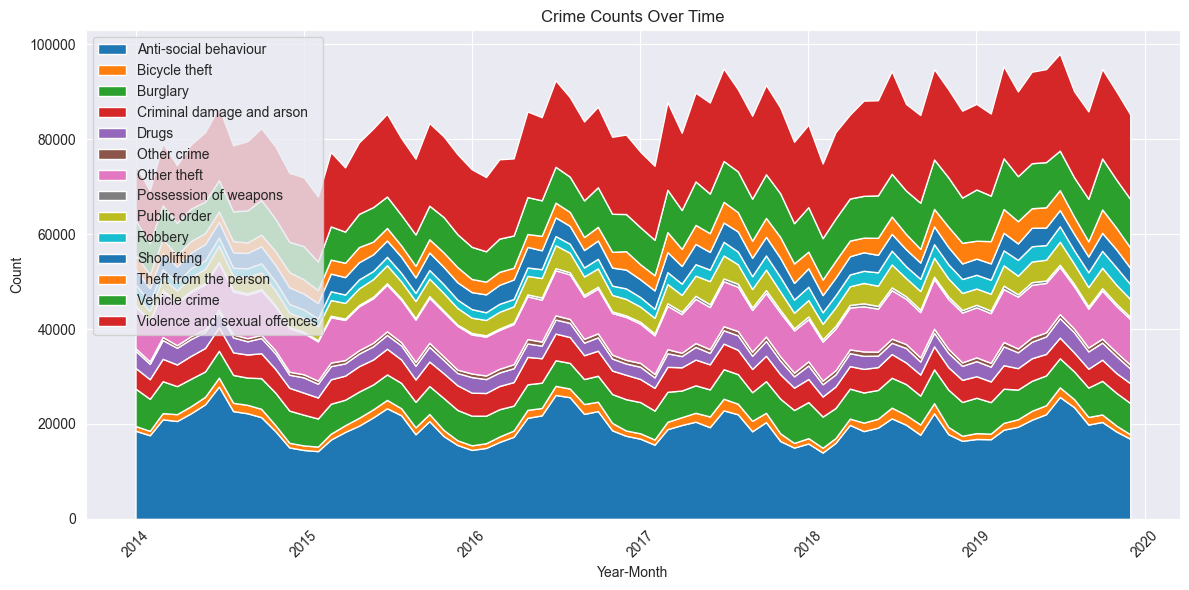

In [14]:
plotter(pivot_df)

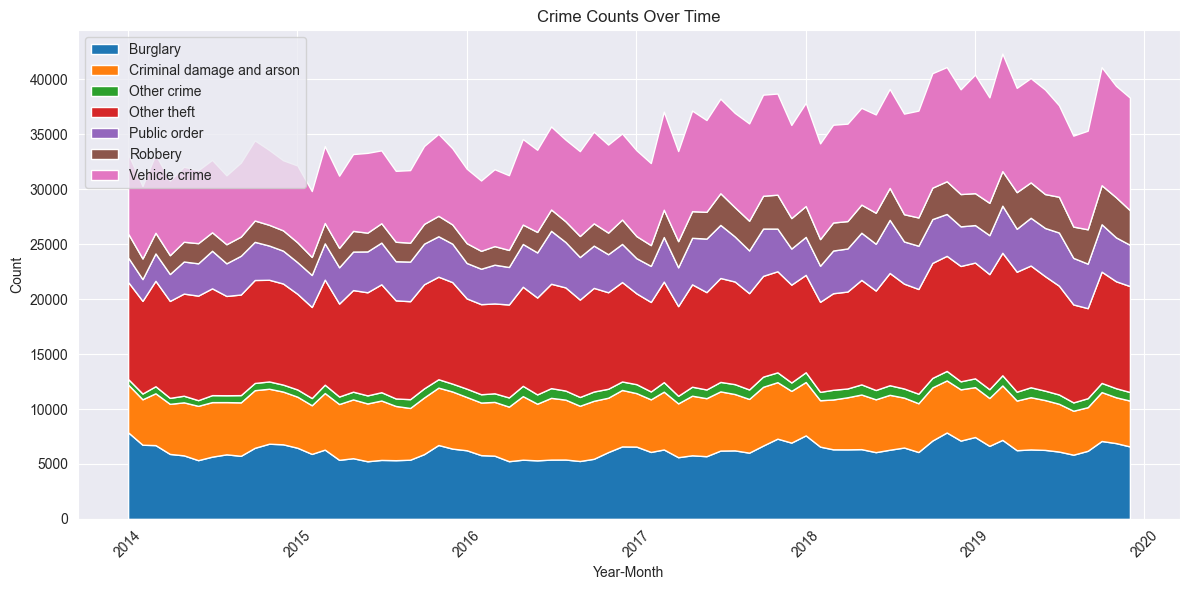

In [15]:
# print(pivot_df[~(pivot_df[under_list])])
cols = pivot_df.columns[~pivot_df.columns.isin(under_list)]

report_df = pivot_df[cols]
plotter(report_df)

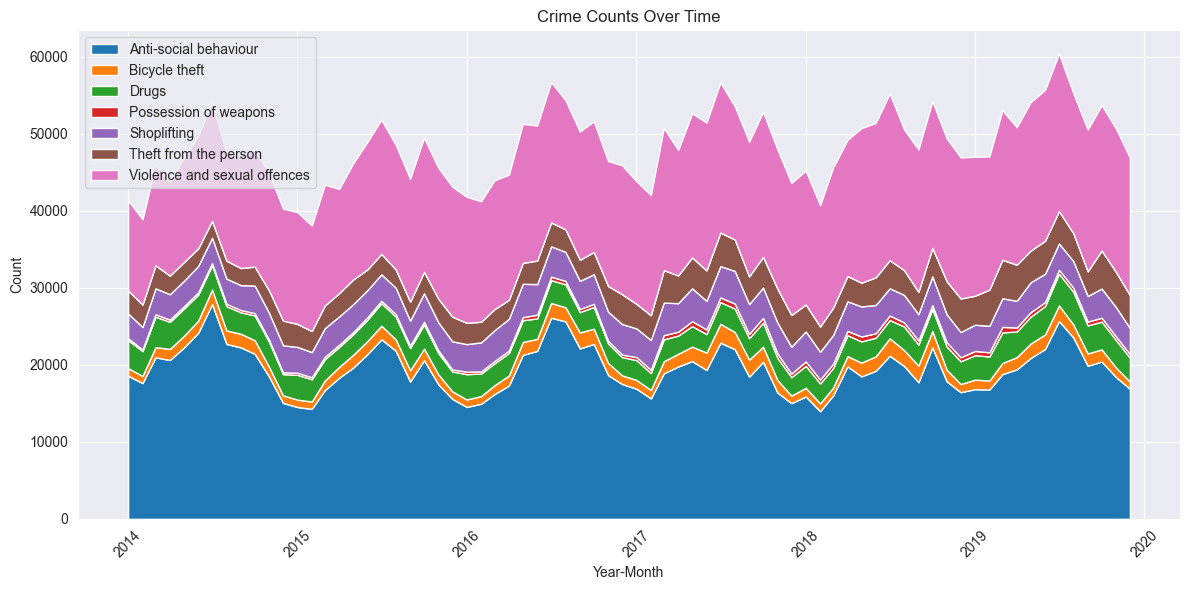

In [16]:
cols = pivot_df.columns[~pivot_df.columns.isin(report_list)]

under_df = pivot_df[cols]
plotter(under_df)